<a href="https://colab.research.google.com/github/Chimata-Bhavya/DataAnalytics/blob/HDFC_Internship/LoanWoE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [591]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [592]:
data = pd.read_csv('/content/bankloan.csv')
data

,ID,Age,Experience,Income,ZIP.Code,Family,CCAvg,Education,Mortgage,Personal.Loan,Securities.Account,CD.Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.5,2,0,0,0,0,1,0


In [593]:
data = data.drop(['ID','ZIP.Code'],axis=1)

In [594]:
data['LoanStatus'] = data['Personal.Loan'].copy()

In [595]:
data = data.drop('Personal.Loan',axis=1)

In [596]:
data['Family'].value_counts()

Family
1    1472
2    1296
4    1222
3    1010
Name: count, dtype: int64

In [597]:
data['LoanStatus'].value_counts()

LoanStatus
0    4520
1     480
Name: count, dtype: int64

In [598]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data,random_state=20,test_size=0.2)
train.dtypes

Age                     int64
Experience              int64
Income                  int64
Family                  int64
CCAvg                 float64
Education               int64
Mortgage                int64
Securities.Account      int64
CD.Account              int64
Online                  int64
CreditCard              int64
LoanStatus              int64
dtype: object

In [599]:
train['Family'].value_counts()

Family
1    1192
2    1020
4     985
3     803
Name: count, dtype: int64

In [600]:
train2 = train.copy()

### Function to calculate WoE

In [601]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]

        lst.append({
            'Bin Values':val,
            'All':dataset[dataset[feature]==val].count()[feature],
            'Good':dataset[(dataset[feature]==val) & (dataset[target]==1)].count()[feature],
            'Bad':dataset[(dataset[feature]==val) & (dataset[target]==0)].count()[feature]
        })

    dset = pd.DataFrame(lst)
    dset['Good %'] = (dset['Good'] / dset['All'])*100
    dset['GoodDist'] = dset['Good'] / dset['Good'].sum()
    dset['BadDist'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['GoodDist'] / dset['BadDist'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['GoodDist'] - dset['BadDist']) * dset['WoE']
    iv = dset['IV'].sum()
    dset = dset.sort_values(by='Bin Values')

    return dset, iv

## Binning, WoE and IV for each variable

# Age

In [602]:
bin_edges = [23, 30, 37, 43, 50, 58, 67, float('inf')]

train2['Age'] = pd.cut(train2['Age'], bins=bin_edges, right=False)

In [603]:
age_woe, age_iv = calculate_woe_iv(train2,'Age','LoanStatus')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [604]:
age_woe

,Bin Values,All,Good,Bad,Good %,GoodDist,BadDist,WoE,IV
1,"[23.0, 30.0)",385,38,347,9.870130,0.102703,0.095592,0.071746,0.000510
4,"[30.0, 37.0)",738,80,658,10.840108,0.216216,0.181267,0.176307,0.006162
2,"[37.0, 43.0)",587,40,547,6.814310,0.108108,0.150689,-0.332084,0.014140
3,"[43.0, 50.0)",692,67,625,9.682081,0.181081,0.172176,0.050426,0.000449
0,"[50.0, 58.0)",835,75,760,8.982036,0.202703,0.209366,-0.032345,0.000216
5,"[58.0, 67.0)",753,70,683,9.296149,0.189189,0.188154,0.005485,0.000006
6,"[67.0, inf)",10,0,10,0.000000,0.000000,0.002755,0.000000,-0.000000


In [605]:
age_iv

0.021482486830640083

### IV for age:
**7 bins : 0.0214**

## -----------------------------------------------------------------------------------------------------



### Experience

In [606]:
train2['Experience'] = train2['Experience'].clip(lower=0)

In [607]:
train2['Experience'] = pd.qcut(train2['Experience'],q=9)

In [608]:
exp_woe, exp_iv = calculate_woe_iv(train2, 'Experience', 'LoanStatus')

In [609]:
exp_woe

,Bin Values,All,Good,Bad,Good %,GoodDist,BadDist,WoE,IV
1,"(-0.001, 5.0]",532,51,481,9.586466,0.137838,0.132507,0.039443,0.000210
5,"(5.0, 9.0]",421,51,370,12.114014,0.137838,0.101928,0.301808,0.010838
3,"(9.0, 14.0]",474,39,435,8.227848,0.105405,0.119835,-0.128299,0.001851
8,"(14.0, 18.0]",393,28,365,7.124682,0.075676,0.100551,-0.284208,0.007070
4,"(18.0, 22.0]",407,41,366,10.073710,0.110811,0.100826,0.094424,0.000943
0,"(22.0, 26.0]",440,36,404,8.181818,0.097297,0.111295,-0.134411,0.001881
6,"(26.0, 31.0]",488,47,441,9.631148,0.127027,0.121488,0.044588,0.000247
2,"(31.0, 35.0]",441,33,408,7.482993,0.089189,0.112397,-0.231275,0.005367
7,"(35.0, 43.0]",404,44,360,10.891089,0.118919,0.099174,0.181571,0.003585


In [610]:
exp_iv

0.03199269237723193

### IV for Experience
  5 bins : 0.0062 |

  6 bins : 0.0062 |

  7 bins : 0.018 |

  8 bins : 0.0126 |

  **9 bins : 0.03199 |**
  
  10 bins : 0.0313

## -------------------------------------------------------------------------------------------------------------------------------

### Income

In [611]:
train2['Income'] = pd.qcut(train2['Income'],q=6)

In [612]:
inc_woe, inc_iv = calculate_woe_iv(train2, 'Income', 'LoanStatus')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [613]:
inc_woe

,Bin Values,All,Good,Bad,Good %,GoodDist,BadDist,WoE,IV
5,"(7.999, 30.0]",699,0,699,0.000000,0.000000,0.192562,0.000000,-0.000000
2,"(30.0, 44.0]",682,0,682,0.000000,0.000000,0.187879,0.000000,-0.000000
1,"(44.0, 64.0]",663,0,663,0.000000,0.000000,0.182645,0.000000,-0.000000
3,"(64.0, 83.0]",632,9,623,1.424051,0.024324,0.171625,-1.953837,0.287802
4,"(83.0, 122.0]",667,83,584,12.443778,0.224324,0.160882,0.332425,0.021090
0,"(122.0, 224.0]",657,278,379,42.313546,0.751351,0.104408,1.973570,1.276788


In [614]:
inc_iv

1.5856805694306269

### IV for Income
**5 bins : 1.959** |
6 bins : 1.585 |
7 bins : 1.951 |
8 bins : 1.678 |
9 bins : 1.901 |
10 bins : 1.708

## -------------------------------------------------------------------------------------------------------------------------------

### Family

In [615]:
bin_edges = [1, 2, 3, 4, float('inf')]

In [616]:
train2['Family'] = pd.cut(train2['Family'],bins=bin_edges,right=False)

In [617]:
fam_woe, fam_iv = calculate_woe_iv(train2, 'Family','LoanStatus')

In [618]:
fam_woe

,Bin Values,All,Good,Bad,Good %,GoodDist,BadDist,WoE,IV
3,"[1.0, 2.0)",1192,82,1110,6.879195,0.221622,0.305785,-0.321911,0.027093
1,"[2.0, 3.0)",1020,83,937,8.137255,0.224324,0.258127,-0.140358,0.004744
2,"[3.0, 4.0)",803,101,702,12.577833,0.272973,0.193388,0.344672,0.027431
0,"[4.0, inf)",985,104,881,10.558376,0.281081,0.242700,0.146818,0.005635


In [619]:
fam_iv

0.06490324421105782

### IV for No of family members
**4 bins : 0.064**

## ------------------------------------------------------------------------------------------------------------------------------

### Credit Card Avg

In [620]:
train2['CCAvg'] = pd.qcut(train2['CCAvg'],q=10)

In [621]:
cc_woe, cc_iv = calculate_woe_iv(train2, 'CCAvg','LoanStatus')

In [622]:
cc_woe

,Bin Values,All,Good,Bad,Good %,GoodDist,BadDist,WoE,IV
3,"(-0.001, 0.29]",400,9,391,2.250000,0.024324,0.107713,-1.487998,0.124083
8,"(0.29, 0.5]",453,14,439,3.090508,0.037838,0.120937,-1.161957,0.096557
6,"(0.5, 0.8]",409,10,399,2.444988,0.027027,0.109917,-1.402891,0.116286
9,"(0.8, 1.2]",387,14,373,3.617571,0.037838,0.102755,-0.999036,0.064854
7,"(1.2, 1.5]",374,13,361,3.475936,0.035135,0.099449,-1.040444,0.066915
1,"(1.5, 1.9]",437,12,425,2.745995,0.032432,0.117080,-1.283698,0.108662
2,"(1.9, 2.2]",341,13,328,3.812317,0.035135,0.090358,-0.944579,0.052162
4,"(2.2, 2.8]",440,25,415,5.681818,0.067568,0.114325,-0.525918,0.024591
0,"(2.8, 4.3]",369,114,255,30.894309,0.308108,0.070248,1.478420,0.351657
5,"(4.3, 10.0]",390,146,244,37.435897,0.394595,0.067218,1.769923,0.579432


In [623]:
cc_iv

1.5851998654714605

### IV for CCAvg
5 bins : 1.558 |
6 bins : 1.478 |
7 bins : 1.466 |
8 bins : 1.583 |
9 bins : 1.571 |
**10 bins : 1.585**

## -------------------------------------------------------------------------------------------------------------------------------

### Mortgage

In [624]:
bin_edges = [0, 100, 200, 300, 400, 635]

In [625]:
train2['Mortgage'] = pd.cut(train2['Mortgage'], bins=bin_edges, include_lowest=True)

In [626]:
mort_woe, mort_iv = calculate_woe_iv(train2, 'Mortgage','LoanStatus')

In [627]:
mort_woe

,Bin Values,All,Good,Bad,Good %,GoodDist,BadDist,WoE,IV
1,"(-0.001, 100.0]",3020,252,2768,8.344371,0.681081,0.762534,-0.112966,0.009201
4,"(100.0, 200.0]",596,30,566,5.033557,0.081081,0.155923,-0.653912,0.048940
3,"(200.0, 300.0]",221,29,192,13.122172,0.078378,0.052893,0.393285,0.010023
2,"(300.0, 400.0]",104,30,74,28.846154,0.081081,0.020386,1.380617,0.083797
0,"(400.0, 635.0]",59,29,30,49.152542,0.078378,0.008264,2.249583,0.157727


In [628]:
mort_iv

0.309688828176134

### IV for Mortgage:
**5 bins : 0.309**
## ----------------------------------------------------------------------------------------------------------------------------

### Education

In [629]:
ed_woe, ed_iv = calculate_woe_iv(train2,'Education','LoanStatus')
ed_woe

,Bin Values,All,Good,Bad,Good %,GoodDist,BadDist,WoE,IV
1,1,1680,70,1610,4.166667,0.189189,0.443526,-0.852009,0.216697
2,2,1103,134,969,12.148685,0.362162,0.266942,0.305060,0.029048
0,3,1217,166,1051,13.640099,0.448649,0.289532,0.437975,0.069689


In [630]:
ed_iv

0.31543460805745893

## ------------------------------------------------------------------------------------------------------------------------------

### Securities Acc

In [631]:
sec_woe, sec_iv = calculate_woe_iv(train2, 'Securities.Account','LoanStatus')
sec_woe

,Bin Values,All,Good,Bad,Good %,GoodDist,BadDist,WoE,IV
0,0,3588,327,3261,9.113712,0.883784,0.898347,-0.016344,0.000238
1,1,412,43,369,10.436893,0.116216,0.101653,0.133888,0.001950


In [632]:
sec_iv

0.0021878841793032374

## ----------------------------------------------------------------------------------------------------------------------------
### CD Acc

In [633]:
cd_woe, cd_iv = calculate_woe_iv(train2, 'CD.Account','LoanStatus')
cd_woe

,Bin Values,All,Good,Bad,Good %,GoodDist,BadDist,WoE,IV
0,0,3763,261,3502,6.935955,0.705405,0.964738,-0.313084,0.081193
1,1,237,109,128,45.991561,0.294595,0.035262,2.122803,0.550513


In [634]:
cd_iv

0.6317055355358078

## ----------------------------------------------------------------------------------------------------------------------------
### Online

In [635]:
on_woe, on_iv = calculate_woe_iv(train2, 'Online','LoanStatus')
on_woe

,Bin Values,All,Good,Bad,Good %,GoodDist,BadDist,WoE,IV
0,0,1613,141,1472,8.741476,0.381081,0.40551,-0.062132,0.001518
1,1,2387,229,2158,9.593632,0.618919,0.59449,0.040270,0.000984


In [636]:
on_iv

0.0025015399960404516

## ----------------------------------------------------------------------------------------------------------------------------
### Credit Card

In [637]:
cred_woe, cred_iv = calculate_woe_iv(train2, 'CreditCard','LoanStatus')
cred_woe

,Bin Values,All,Good,Bad,Good %,GoodDist,BadDist,WoE,IV
0,0,2810,259,2551,9.217082,0.7,0.702755,-0.003928,0.000011
1,1,1190,111,1079,9.327731,0.3,0.297245,0.009225,0.000025


In [638]:
cred_iv

3.623386362664721e-05

## -----------------------------------------------------------------------------------------------------------------------------

In [639]:
lst = []
IV_df = pd.DataFrame(columns=['Variable','IV'])
for col in data.columns:
    if col == 'LoanStatus': continue
    else:
        df, iv = calculate_woe_iv(train2, col, 'LoanStatus')
    new_row = pd.DataFrame({"Variable": [col], "IV": [iv]})
    IV_df = pd.concat([IV_df, new_row],ignore_index=True)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [640]:
def interpret_iv(IV):
    if IV < 0.02:
        return 'Not useful'
    elif IV < 0.1:
        return 'Weak'
    elif 0.1< IV < 0.3:
        return 'Medium'
    elif 0.3<IV<0.5:
        return 'Strong'
    elif IV>0.5:
        return 'Suspicious'

IV_df['IV_Interpretation'] = IV_df['IV'].apply(interpret_iv)

### IV

In [641]:
IV_df

,Variable,IV,IV_Interpretation
0,Age,0.021482,Weak
1,Experience,0.031993,Weak
2,Income,1.585681,Suspicious
3,Family,0.064903,Weak
4,CCAvg,1.585200,Suspicious
5,Education,0.315435,Strong
6,Mortgage,0.309689,Strong
7,Securities.Account,0.002188,Not useful
8,CD.Account,0.631706,Suspicious
9,Online,0.002502,Not useful


### Mapping bins back to their respective WoE values

In [642]:
dfs = [age_woe,exp_woe,inc_woe,fam_woe,cc_woe,ed_woe,mort_woe,sec_woe,cd_woe,on_woe,cred_woe]

In [643]:
for i, df in enumerate(dfs, 1):
    print(f"DataFrame {i}")
    display(df)
    print("No. of bins: ",len(df))
    print('IV',df["IV"].sum())
    print("\n")

DataFrame 1


,Bin Values,All,Good,Bad,Good %,GoodDist,BadDist,WoE,IV
1,"[23.0, 30.0)",385,38,347,9.870130,0.102703,0.095592,0.071746,0.000510
4,"[30.0, 37.0)",738,80,658,10.840108,0.216216,0.181267,0.176307,0.006162
2,"[37.0, 43.0)",587,40,547,6.814310,0.108108,0.150689,-0.332084,0.014140
3,"[43.0, 50.0)",692,67,625,9.682081,0.181081,0.172176,0.050426,0.000449
0,"[50.0, 58.0)",835,75,760,8.982036,0.202703,0.209366,-0.032345,0.000216
5,"[58.0, 67.0)",753,70,683,9.296149,0.189189,0.188154,0.005485,0.000006
6,"[67.0, inf)",10,0,10,0.000000,0.000000,0.002755,0.000000,-0.000000


No. of bins:  7
IV 0.021482486830640087


DataFrame 2


,Bin Values,All,Good,Bad,Good %,GoodDist,BadDist,WoE,IV
1,"(-0.001, 5.0]",532,51,481,9.586466,0.137838,0.132507,0.039443,0.000210
5,"(5.0, 9.0]",421,51,370,12.114014,0.137838,0.101928,0.301808,0.010838
3,"(9.0, 14.0]",474,39,435,8.227848,0.105405,0.119835,-0.128299,0.001851
8,"(14.0, 18.0]",393,28,365,7.124682,0.075676,0.100551,-0.284208,0.007070
4,"(18.0, 22.0]",407,41,366,10.073710,0.110811,0.100826,0.094424,0.000943
0,"(22.0, 26.0]",440,36,404,8.181818,0.097297,0.111295,-0.134411,0.001881
6,"(26.0, 31.0]",488,47,441,9.631148,0.127027,0.121488,0.044588,0.000247
2,"(31.0, 35.0]",441,33,408,7.482993,0.089189,0.112397,-0.231275,0.005367
7,"(35.0, 43.0]",404,44,360,10.891089,0.118919,0.099174,0.181571,0.003585


No. of bins:  9
IV 0.03199269237723193


DataFrame 3


,Bin Values,All,Good,Bad,Good %,GoodDist,BadDist,WoE,IV
5,"(7.999, 30.0]",699,0,699,0.000000,0.000000,0.192562,0.000000,-0.000000
2,"(30.0, 44.0]",682,0,682,0.000000,0.000000,0.187879,0.000000,-0.000000
1,"(44.0, 64.0]",663,0,663,0.000000,0.000000,0.182645,0.000000,-0.000000
3,"(64.0, 83.0]",632,9,623,1.424051,0.024324,0.171625,-1.953837,0.287802
4,"(83.0, 122.0]",667,83,584,12.443778,0.224324,0.160882,0.332425,0.021090
0,"(122.0, 224.0]",657,278,379,42.313546,0.751351,0.104408,1.973570,1.276788


No. of bins:  6
IV 1.5856805694306269


DataFrame 4


,Bin Values,All,Good,Bad,Good %,GoodDist,BadDist,WoE,IV
3,"[1.0, 2.0)",1192,82,1110,6.879195,0.221622,0.305785,-0.321911,0.027093
1,"[2.0, 3.0)",1020,83,937,8.137255,0.224324,0.258127,-0.140358,0.004744
2,"[3.0, 4.0)",803,101,702,12.577833,0.272973,0.193388,0.344672,0.027431
0,"[4.0, inf)",985,104,881,10.558376,0.281081,0.242700,0.146818,0.005635


No. of bins:  4
IV 0.06490324421105782


DataFrame 5


,Bin Values,All,Good,Bad,Good %,GoodDist,BadDist,WoE,IV
3,"(-0.001, 0.29]",400,9,391,2.250000,0.024324,0.107713,-1.487998,0.124083
8,"(0.29, 0.5]",453,14,439,3.090508,0.037838,0.120937,-1.161957,0.096557
6,"(0.5, 0.8]",409,10,399,2.444988,0.027027,0.109917,-1.402891,0.116286
9,"(0.8, 1.2]",387,14,373,3.617571,0.037838,0.102755,-0.999036,0.064854
7,"(1.2, 1.5]",374,13,361,3.475936,0.035135,0.099449,-1.040444,0.066915
1,"(1.5, 1.9]",437,12,425,2.745995,0.032432,0.117080,-1.283698,0.108662
2,"(1.9, 2.2]",341,13,328,3.812317,0.035135,0.090358,-0.944579,0.052162
4,"(2.2, 2.8]",440,25,415,5.681818,0.067568,0.114325,-0.525918,0.024591
0,"(2.8, 4.3]",369,114,255,30.894309,0.308108,0.070248,1.478420,0.351657
5,"(4.3, 10.0]",390,146,244,37.435897,0.394595,0.067218,1.769923,0.579432


No. of bins:  10
IV 1.585199865471461


DataFrame 6


,Bin Values,All,Good,Bad,Good %,GoodDist,BadDist,WoE,IV
1,1,1680,70,1610,4.166667,0.189189,0.443526,-0.852009,0.216697
2,2,1103,134,969,12.148685,0.362162,0.266942,0.305060,0.029048
0,3,1217,166,1051,13.640099,0.448649,0.289532,0.437975,0.069689


No. of bins:  3
IV 0.31543460805745893


DataFrame 7


,Bin Values,All,Good,Bad,Good %,GoodDist,BadDist,WoE,IV
1,"(-0.001, 100.0]",3020,252,2768,8.344371,0.681081,0.762534,-0.112966,0.009201
4,"(100.0, 200.0]",596,30,566,5.033557,0.081081,0.155923,-0.653912,0.048940
3,"(200.0, 300.0]",221,29,192,13.122172,0.078378,0.052893,0.393285,0.010023
2,"(300.0, 400.0]",104,30,74,28.846154,0.081081,0.020386,1.380617,0.083797
0,"(400.0, 635.0]",59,29,30,49.152542,0.078378,0.008264,2.249583,0.157727


No. of bins:  5
IV 0.30968882817613397


DataFrame 8


,Bin Values,All,Good,Bad,Good %,GoodDist,BadDist,WoE,IV
0,0,3588,327,3261,9.113712,0.883784,0.898347,-0.016344,0.000238
1,1,412,43,369,10.436893,0.116216,0.101653,0.133888,0.001950


No. of bins:  2
IV 0.0021878841793032374


DataFrame 9


,Bin Values,All,Good,Bad,Good %,GoodDist,BadDist,WoE,IV
0,0,3763,261,3502,6.935955,0.705405,0.964738,-0.313084,0.081193
1,1,237,109,128,45.991561,0.294595,0.035262,2.122803,0.550513


No. of bins:  2
IV 0.6317055355358078


DataFrame 10


,Bin Values,All,Good,Bad,Good %,GoodDist,BadDist,WoE,IV
0,0,1613,141,1472,8.741476,0.381081,0.40551,-0.062132,0.001518
1,1,2387,229,2158,9.593632,0.618919,0.59449,0.040270,0.000984


No. of bins:  2
IV 0.0025015399960404516


DataFrame 11


,Bin Values,All,Good,Bad,Good %,GoodDist,BadDist,WoE,IV
0,0,2810,259,2551,9.217082,0.7,0.702755,-0.003928,0.000011
1,1,1190,111,1079,9.327731,0.3,0.297245,0.009225,0.000025


No. of bins:  2
IV 3.623386362664721e-05




In [644]:
age_woe_df = age_woe[['Bin Values','WoE']]
exp_woe_df = exp_woe[['Bin Values','WoE']]
inc_woe_df = inc_woe[['Bin Values','WoE']]
fam_woe_df = fam_woe[['Bin Values','WoE']]
cc_woe_df = cc_woe[['Bin Values','WoE']]
ed_woe_df = ed_woe[['Bin Values','WoE']]
mort_woe_df = mort_woe[['Bin Values','WoE']]
sec_woe_df = sec_woe[['Bin Values','WoE']]
cd_woe_df = cd_woe[['Bin Values','WoE']]
on_woe_df = on_woe[['Bin Values','WoE']]
cred_woe_df = cred_woe[['Bin Values','WoE']]


woe_dfs = {
    'Age':age_woe_df,
    'Experience':exp_woe_df,
    'Income':inc_woe_df,
    'Family':fam_woe_df,
    'CCAvg':cc_woe_df,
    'Education':ed_woe_df,
    'Mortgage':mort_woe_df,
    'Securities.Account':sec_woe_df,
    'CD.Account':cd_woe_df,
    'Online':on_woe_df,
    'CreditCard':cred_woe_df
}

In [645]:
def get_woe_value(bin_value, feature_name):
    woe_df = woe_dfs[feature_name]
    return woe_df.loc[woe_df['Bin Values'] == bin_value, 'WoE'].values[0]

In [646]:
for feature in train2.columns:
    if feature == 'LoanStatus':
        continue
    train2[feature] = train2[feature].apply(lambda x: get_woe_value(x, feature))
train2

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities.Account,CD.Account,Online,CreditCard,LoanStatus
3702,-0.032345,-0.134411,1.973570,0.146818,1.478420,0.437975,2.249583,-0.016344,-0.313084,-0.062132,-0.003928,1
4393,0.071746,0.039443,0.000000,0.146818,-1.283698,-0.852009,-0.112966,-0.016344,-0.313084,-0.062132,-0.003928,0
226,0.071746,0.039443,0.000000,-0.140358,-1.283698,0.305060,-0.112966,-0.016344,-0.313084,-0.062132,-0.003928,0
913,-0.032345,-0.231275,0.000000,-0.140358,-0.944579,0.305060,-0.112966,0.133888,-0.313084,-0.062132,-0.003928,0
542,-0.332084,-0.128299,-1.953837,0.344672,-1.487998,-0.852009,-0.112966,-0.016344,-0.313084,0.040270,-0.003928,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1607,-0.032345,0.044588,0.000000,0.146818,-1.402891,0.437975,-0.112966,-0.016344,-0.313084,-0.062132,-0.003928,0
3915,-0.332084,-0.128299,0.332425,-0.321911,-0.525918,-0.852009,-0.112966,-0.016344,-0.313084,0.040270,0.009225,0
1428,0.071746,0.039443,0.000000,0.146818,-1.161957,-0.852009,-0.112966,-0.016344,-0.313084,0.040270,-0.003928,0
4367,-0.332084,-0.284208,1.973570,-0.140358,1.478420,-0.852009,1.380617,-0.016344,-0.313084,0.040270,0.009225,0


### Function to create KS Table

In [647]:
def calculate_ks_statistic(df, score_column, status_column, good_value=1, bad_value=0):
    df['decile'] = pd.qcut(df[score_column], 10)

    ks_table = df.groupby('decile').agg(
        count=(status_column, 'size'),
        bad=(status_column, lambda x: (x == bad_value).sum()),
        good=(status_column, lambda x: (x == good_value).sum())
    ).reset_index()

    ks_table = ks_table.sort_values(by=['decile'], ascending=False)

    ks_table['bad_cum'] = ks_table['bad'].cumsum()
    ks_table['good_cum'] = ks_table['good'].cumsum()


    total_bad = ks_table['bad'].sum()
    total_good = ks_table['good'].sum()

    ks_table['good %'] = (ks_table['good'] / total_good) * 100
    ks_table['bad %'] = (ks_table['bad'] / total_bad) * 100

    ks_table['bad_cum_perc'] = (ks_table['bad_cum'] / total_bad) * 100
    ks_table['good_cum_perc'] = (ks_table['good_cum'] / total_good) * 100

    ks_table['ks'] = np.abs(ks_table['bad_cum_perc'] - ks_table['good_cum_perc'])
    ks_stat = ks_table['ks'].max()

    return ks_stat, ks_table
IV_df

,Variable,IV,IV_Interpretation
0,Age,0.021482,Weak
1,Experience,0.031993,Weak
2,Income,1.585681,Suspicious
3,Family,0.064903,Weak
4,CCAvg,1.585200,Suspicious
5,Education,0.315435,Strong
6,Mortgage,0.309689,Strong
7,Securities.Account,0.002188,Not useful
8,CD.Account,0.631706,Suspicious
9,Online,0.002502,Not useful


## Model 1

In [648]:
train3 = train2.copy()
test3 = test.copy()

In [649]:
train3 = train3.drop(['Securities.Account','Online','CreditCard'],axis=1)

In [650]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [651]:
x = train3.iloc[:,:-1]
y = train3.iloc[:,-1]

In [652]:
lr = LogisticRegression()
model1 = lr.fit(x,y)

In [653]:
result1 = model1.predict_proba(x)

In [654]:
result1 = pd.DataFrame(result1)

In [655]:
result1

,0,1
0,0.008990,0.991010
1,0.999594,0.000406
2,0.991594,0.008406
3,0.990000,0.010000
4,0.999994,0.000006
...,...,...
3995,0.972658,0.027342
3996,0.999716,0.000284
3997,0.999543,0.000457
3998,0.785481,0.214519


Desired class : 1

In [656]:
train3.reset_index(drop=True, inplace=True)

In [657]:
result1['LoanStatus'] = train3['LoanStatus']
result1

,0,1,LoanStatus
0,0.008990,0.991010,1
1,0.999594,0.000406,0
2,0.991594,0.008406,0
3,0.990000,0.010000,0
4,0.999994,0.000006,0
...,...,...,...
3995,0.972658,0.027342,0
3996,0.999716,0.000284,0
3997,0.999543,0.000457,0
3998,0.785481,0.214519,0


In [658]:
result1 = result1.drop(0,axis=1)
result1

,1,LoanStatus
0,0.991010,1
1,0.000406,0
2,0.008406,0
3,0.010000,0
4,0.000006,0
...,...,...
3995,0.027342,0
3996,0.000284,0
3997,0.000457,0
3998,0.214519,0


In [659]:
ks_stat1, ks_table1 = calculate_ks_statistic(result1, 1, 'LoanStatus')
print('Model 1\nKS table with columns:',train3.columns,'\n')
ks_table1

Model 1
KS table with columns: Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education',
       'Mortgage', 'CD.Account', 'LoanStatus'],
      dtype='object') 



,decile,count,bad,good,bad_cum,good_cum,good %,bad %,bad_cum_perc,good_cum_perc,ks
9,"(0.214, 1.0]",400,90,310,90,310,83.783784,2.479339,2.479339,83.783784,81.304445
8,"(0.0702, 0.214]",399,375,24,465,334,6.486486,10.330579,12.809917,90.270270,77.460353
7,"(0.0323, 0.0702]",399,390,9,855,343,2.432432,10.743802,23.553719,92.702703,69.148984
6,"(0.0173, 0.0323]",401,391,10,1246,353,2.702703,10.771350,34.325069,95.405405,61.080337
5,"(0.00851, 0.0173]",401,397,4,1643,357,1.081081,10.936639,45.261708,96.486486,51.224778
4,"(0.00455, 0.00851]",399,394,5,2037,362,1.351351,10.853994,56.115702,97.837838,41.722135
3,"(0.000736, 0.00455]",398,393,5,2430,367,1.351351,10.826446,66.942149,99.189189,32.247040
2,"(0.000303, 0.000736]",403,403,0,2833,367,0.000000,11.101928,78.044077,99.189189,21.145112
1,"(9.97e-05, 0.000303]",397,397,0,3230,367,0.000000,10.936639,88.980716,99.189189,10.208473
0,"(-0.000999354, 9.97e-05]",403,400,3,3630,370,0.810811,11.019284,100.000000,100.000000,0.000000


In [660]:
print('KS Statistic: ',ks_stat1,'at decile 1')

KS Statistic:  81.30444494080858 at decile 1


In [661]:
train3.columns

Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education',
       'Mortgage', 'CD.Account', 'LoanStatus'],
      dtype='object')

In [662]:
test3.columns

Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education',
       'Mortgage', 'Securities.Account', 'CD.Account', 'Online', 'CreditCard',
       'LoanStatus'],
      dtype='object')

In [663]:
test3 = test3.drop(['Securities.Account','Online','CreditCard'],axis=1)

X_test = test3.drop(columns=['LoanStatus'])
y_test = test3['LoanStatus']

# Make predictions
# Assuming your model has a `predict` method. Replace with your actual model's prediction method if different
y_pred = model1.predict(X_test)

# Calculate accuracy
accuracy1 = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy1 * 100:.2f}%")

Test Accuracy: 11.00%


## Model 2

In [664]:
train4 = train2.copy()
test4 = test.copy()

train4 = train4.drop(['Securities.Account','Online','CreditCard','Age','Experience','Family'],axis=1)

x = train4.iloc[:,:-1]
y = train4.iloc[:,-1]

model2 = lr.fit(x,y)
result2 = model2.predict_proba(x)

result2 = pd.DataFrame(result2)
result2

,0,1
0,0.021915,0.978085
1,0.999698,0.000302
2,0.984204,0.015796
3,0.978854,0.021146
4,0.999995,0.000005
...,...,...
3995,0.977686,0.022314
3996,0.998851,0.001149
3997,0.999664,0.000336
3998,0.734752,0.265248


In [665]:
train4.reset_index(drop=True,inplace=True)
result2['LoanStatus'] = train4['LoanStatus']
result2

,0,1,LoanStatus
0,0.021915,0.978085,1
1,0.999698,0.000302,0
2,0.984204,0.015796,0
3,0.978854,0.021146,0
4,0.999995,0.000005,0
...,...,...,...
3995,0.977686,0.022314,0
3996,0.998851,0.001149,0
3997,0.999664,0.000336,0
3998,0.734752,0.265248,0


In [666]:
result2 = result2.drop(0,axis=1)

In [667]:
ks_stat2, ks_table2 = calculate_ks_statistic(result2, 1, 'LoanStatus')
print('Model2\nKS table with columns:',train4.columns,'\n')
ks_table2

Model2
KS table with columns: Index(['Income', 'CCAvg', 'Education', 'Mortgage', 'CD.Account', 'LoanStatus'], dtype='object') 



,decile,count,bad,good,bad_cum,good_cum,good %,bad %,bad_cum_perc,good_cum_perc,ks
9,"(0.225, 0.999]",400,103,297,103,297,80.270270,2.837466,2.837466,80.270270,77.432805
8,"(0.0474, 0.225]",399,359,40,462,337,10.810811,9.889807,12.727273,91.081081,78.353808
7,"(0.0302, 0.0474]",393,386,7,848,344,1.891892,10.633609,23.360882,92.972973,69.612091
6,"(0.0217, 0.0302]",405,402,3,1250,347,0.810811,11.074380,34.435262,93.783784,59.348522
5,"(0.0175, 0.0217]",344,341,3,1591,350,0.810811,9.393939,43.829201,94.594595,50.765393
4,"(0.00862, 0.0175]",459,454,5,2045,355,1.351351,12.506887,56.336088,95.945946,39.609858
3,"(0.000603, 0.00862]",397,386,11,2431,366,2.972973,10.633609,66.969697,98.918919,31.949222
2,"(0.000378, 0.000603]",400,399,1,2830,367,0.270270,10.991736,77.961433,99.189189,21.227757
1,"(0.000264, 0.000378]",382,382,0,3212,367,0.000000,10.523416,88.484848,99.189189,10.704341
0,"(-0.00099623, 0.000264]",421,418,3,3630,370,0.810811,11.515152,100.000000,100.000000,0.000000


In [668]:
print('KS Statistic: ',ks_stat2,'at decile 2')

KS Statistic:  78.35380835380835 at decile 2


In [669]:
test4 = test4.drop(['Securities.Account','Online','CreditCard','Age','Experience','Family'],axis=1)

X_test = test4.drop(columns=['LoanStatus'])
y_test = test4['LoanStatus']

# Make predictions
# Assuming your model has a `predict` method. Replace with your actual model's prediction method if different
y_pred = model2.predict(X_test)

# Calculate accuracy
accuracy2 = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy2 * 100:.2f}%")

Test Accuracy: 11.00%


## Model 3

In [670]:
train5 = train2.copy()
test5 = test.copy()

train5 = train5.drop(['Securities.Account','Online','CreditCard','Age'],axis=1)

x = train5.iloc[:,:-1]
y = train5.iloc[:,-1]

model3 = lr.fit(x,y)

result3 = model3.predict_proba(x)
result3 = pd.DataFrame(result3)
result3

,0,1
0,0.009229,0.990771
1,0.999610,0.000390
2,0.991949,0.008051
3,0.990410,0.009590
4,0.999993,0.000007
...,...,...
3995,0.971897,0.028103
3996,0.999656,0.000344
3997,0.999561,0.000439
3998,0.759415,0.240585


In [671]:
train5.reset_index(drop=True,inplace=True)
result3['LoanStatus'] = train5['LoanStatus']
result3 = result3.drop(0,axis=1)
result3

,1,LoanStatus
0,0.990771,1
1,0.000390,0
2,0.008051,0
3,0.009590,0
4,0.000007,0
...,...,...
3995,0.028103,0
3996,0.000344,0
3997,0.000439,0
3998,0.240585,0


In [672]:
ks_stat3, ks_table3 = calculate_ks_statistic(result3, 1, 'LoanStatus')
print('Model 3\nKS table with columns:',train5.columns,'\n')
ks_table3

Model 3
KS table with columns: Index(['Experience', 'Income', 'Family', 'CCAvg', 'Education', 'Mortgage',
       'CD.Account', 'LoanStatus'],
      dtype='object') 



,decile,count,bad,good,bad_cum,good_cum,good %,bad %,bad_cum_perc,good_cum_perc,ks
9,"(0.216, 1.0]",399,91,308,91,308,83.243243,2.506887,2.506887,83.243243,80.736356
8,"(0.0683, 0.216]",397,372,25,463,333,6.756757,10.247934,12.754821,90.000000,77.245179
7,"(0.0319, 0.0683]",396,384,12,847,345,3.243243,10.578512,23.333333,93.243243,69.909910
6,"(0.017, 0.0319]",408,400,8,1247,353,2.162162,11.019284,34.352617,95.405405,61.052788
5,"(0.00846, 0.017]",400,395,5,1642,358,1.351351,10.881543,45.234160,96.756757,51.522597
4,"(0.00468, 0.00846]",400,396,4,2038,362,1.081081,10.909091,56.143251,97.837838,41.694587
3,"(0.00074, 0.00468]",400,395,5,2433,367,1.351351,10.881543,67.024793,99.189189,32.164396
2,"(0.000299, 0.00074]",395,395,0,2828,367,0.000000,10.881543,77.906336,99.189189,21.282853
1,"(9.89e-05, 0.000299]",405,405,0,3233,367,0.000000,11.157025,89.063361,99.189189,10.125828
0,"(-0.000999329, 9.89e-05]",400,397,3,3630,370,0.810811,10.936639,100.000000,100.000000,0.000000


In [673]:
print("KS Statistic: ",ks_stat3,'at decile 1')

KS Statistic:  80.73635619090165 at decile 1


In [674]:
test5 = test5.drop(['Securities.Account','Online','CreditCard','Age'],axis=1)

X_test = test5.drop(columns=['LoanStatus'])
y_test = test5['LoanStatus']

# Make predictions
# Assuming your model has a `predict` method. Replace with your actual model's prediction method if different
y_pred = model3.predict(X_test)

# Calculate accuracy
accuracy3 = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy3 * 100:.2f}%")

Test Accuracy: 11.00%


## Model 4

In [675]:
train6 = train2.copy()
test6 = test.copy()

train6 = train6.drop(['Securities.Account','Online','CreditCard','Age','Experience','Family','Income'],axis=1)

x = train6.iloc[:,:-1]
y = train6.iloc[:,-1]

model4 = lr.fit(x,y)
result4 = model4.predict_proba(x)
result4 = pd.DataFrame(result4)

result4

,0,1
0,0.102338,0.897662
1,0.997353,0.002647
2,0.973801,0.026199
3,0.960759,0.039241
4,0.997941,0.002059
...,...,...
3995,0.970577,0.029423
3996,0.993300,0.006700
3997,0.996927,0.003073
3998,0.766906,0.233094


In [676]:
train6.reset_index(drop=True,inplace=True)
result4['LoanStatus'] = train6['LoanStatus']
result4 = result4.drop(0,axis=1)

In [677]:
ks_stat4, ks_table4 = calculate_ks_statistic(result4, 1, 'LoanStatus')
print('Model 4\nKS table with columns:',train6.columns,'\n')
ks_table4

Model 4
KS table with columns: Index(['CCAvg', 'Education', 'Mortgage', 'CD.Account', 'LoanStatus'], dtype='object') 



,decile,count,bad,good,bad_cum,good_cum,good %,bad %,bad_cum_perc,good_cum_perc,ks
9,"(0.316, 0.993]",397,147,250,147,250,67.567568,4.049587,4.049587,67.567568,63.517981
8,"(0.0754, 0.316]",391,347,44,494,294,11.891892,9.559229,13.608815,79.459459,65.850644
7,"(0.0506, 0.0754]",325,307,18,801,312,4.864865,8.457300,22.066116,84.324324,62.258209
6,"(0.0392, 0.0506]",412,391,21,1192,333,5.675676,10.771350,32.837466,90.000000,57.162534
5,"(0.0303, 0.0392]",449,442,7,1634,340,1.891892,12.176309,45.013774,91.891892,46.878118
4,"(0.0262, 0.0303]",338,332,6,1966,346,1.621622,9.146006,54.159780,93.513514,39.353734
3,"(0.0165, 0.0262]",488,478,10,2444,356,2.702703,13.168044,67.327824,96.216216,28.888393
2,"(0.00375, 0.0165]",369,362,7,2806,363,1.891892,9.972452,77.300275,98.108108,20.807833
1,"(0.00265, 0.00375]",355,352,3,3158,366,0.810811,9.696970,86.997245,98.918919,11.921674
0,"(0.00027000000000000006, 0.00265]",476,472,4,3630,370,1.081081,13.002755,100.000000,100.000000,0.000000


In [678]:
print("KS Statistic: ",ks_stat4,'at decile 2')

KS Statistic:  65.85064403246221 at decile 2


In [679]:
test6 = test6.drop(['Securities.Account','Online','CreditCard','Age','Experience','Family','Income'],axis=1)

X_test = test6.drop(columns=['LoanStatus'])
y_test = test6['LoanStatus']

# Make predictions
# Assuming your model has a `predict` method. Replace with your actual model's prediction method if different
y_pred = model4.predict(X_test)

# Calculate accuracy
accuracy4 = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy4 * 100:.2f}%")

Test Accuracy: 12.30%


## Model 5

In [680]:
train7 = train2.copy()
test7 = test.copy()

train7 = train7.drop(['Securities.Account','Online','CreditCard','Age','Experience','Family','Income','CD.Account'],axis=1)

x = train7.iloc[:,:-1]
y = train7.iloc[:,-1]

model5 = lr.fit(x,y)
result5 = model5.predict_proba(x)
result5 = pd.DataFrame(result5)

result5

,0,1
0,0.083591,0.916409
1,0.996386,0.003614
2,0.965751,0.034249
3,0.948736,0.051264
4,0.997193,0.002807
...,...,...
3995,0.961777,0.038223
3996,0.990791,0.009209
3997,0.995798,0.004202
3998,0.710633,0.289367


In [681]:
train7.reset_index(drop=True,inplace=True)
result5['LoanStatus'] = train7['LoanStatus']
result5 = result5.drop(0,axis=1)

In [682]:
ks_stat5, ks_table5 = calculate_ks_statistic(result5, 1, 'LoanStatus')
print('Model 5\nKS table with columns:',train7.columns,'\n')
ks_table5

Model 5
KS table with columns: Index(['CCAvg', 'Education', 'Mortgage', 'LoanStatus'], dtype='object') 



,decile,count,bad,good,bad_cum,good_cum,good %,bad %,bad_cum_perc,good_cum_perc,ks
9,"(0.148, 0.94]",393,163,230,163,230,62.162162,4.490358,4.490358,62.162162,57.671804
8,"(0.101, 0.148]",294,259,35,422,265,9.459459,7.134986,11.625344,71.621622,59.996277
7,"(0.0616, 0.101]",462,430,32,852,297,8.648649,11.845730,23.471074,80.270270,56.799196
6,"(0.0481, 0.0616]",422,394,28,1246,325,7.567568,10.853994,34.325069,87.837838,53.512769
5,"(0.0395, 0.0481]",419,412,7,1658,332,1.891892,11.349862,45.674931,89.729730,44.054799
4,"(0.0325, 0.0395]",405,394,11,2052,343,2.972973,10.853994,56.528926,92.702703,36.173777
3,"(0.0169, 0.0325]",399,393,6,2445,349,1.621622,10.826446,67.355372,94.324324,26.968952
2,"(0.00514, 0.0169]",339,328,11,2773,360,2.972973,9.035813,76.391185,97.297297,20.906113
1,"(0.00361, 0.00514]",370,366,4,3139,364,1.081081,10.082645,86.473829,98.378378,11.904549
0,"(0.00076, 0.00361]",497,491,6,3630,370,1.621622,13.526171,100.000000,100.000000,0.000000


In [683]:
print("KS Statistic: ",ks_stat5,' at decile 2')

KS Statistic:  59.99627726900455  at decile 2


In [684]:
test7 = test7.drop(['Securities.Account','Online','CreditCard','Age','Experience','Family','Income','CD.Account'],axis=1)

X_test = test7.drop(columns=['LoanStatus'])
y_test = test7['LoanStatus']

# Make predictions
# Assuming your model has a `predict` method. Replace with your actual model's prediction method if different
y_pred = model5.predict(X_test)

# Calculate accuracy
accuracy5 = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy5 * 100:.2f}%")

Test Accuracy: 13.70%


Training metrics:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3630
           1       0.69      0.55      0.61       370

    accuracy                           0.94      4000
   macro avg       0.82      0.76      0.79      4000
weighted avg       0.93      0.94      0.93      4000



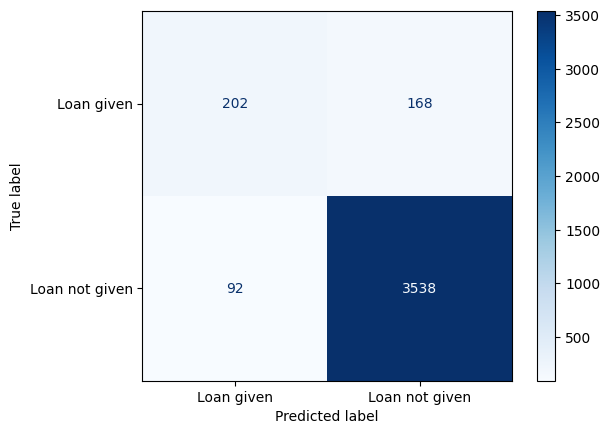

[[ 202  168]
 [  92 3538]]
Test metrics:
              precision    recall  f1-score   support

           0       0.97      0.03      0.06       890
           1       0.11      0.99      0.20       110

    accuracy                           0.14      1000
   macro avg       0.54      0.51      0.13      1000
weighted avg       0.87      0.14      0.08      1000



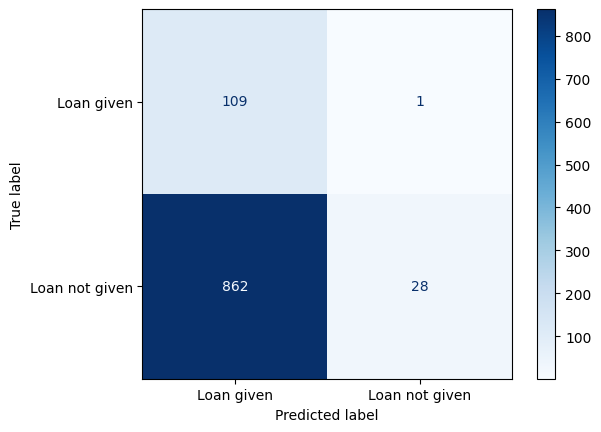

[[109   1]
 [862  28]]


In [685]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print('Training metrics:')
print(classification_report(y, model5.predict(x)))

class_names = [1, 0]
dis_names = ['Loan given', 'Loan not given']

cm = confusion_matrix(y, model5.predict(x), labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dis_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print(cm)

print('Test metrics:')
print(classification_report(y_test, model5.predict(X_test)))
class_names = [1, 0]
dis_names = ['Loan given', 'Loan not given']

cm = confusion_matrix(y_test, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dis_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print(cm)

## Model 6

In [686]:
train8  = train2.copy()
test8 = test.copy()

train8 = train8.drop(['Securities.Account','Online','CreditCard','Age','Experience','Family','Mortgage','CD.Account'],axis=1)

x = train8.iloc[:,:-1]
y = train8.iloc[:,-1]

model6 = lr.fit(x,y)
result6 = model6.predict_proba(x)
result6 = pd.DataFrame(result6)

result6

,0,1
0,0.039433,0.960567
1,0.999635,0.000365
2,0.979502,0.020498
3,0.972736,0.027264
4,0.999995,0.000005
...,...,...
3995,0.970809,0.029191
3996,0.998576,0.001424
3997,0.999595,0.000405
3998,0.789399,0.210601


In [687]:
train8.reset_index(drop=True,inplace=True)
result6['LoanStatus'] = train8['LoanStatus']
result6 = result6.drop(0,axis=1)

In [688]:
ks_stat6, ks_table6 = calculate_ks_statistic(result6, 1, 'LoanStatus')
print('Model 6\nKS table with columns:',train8.columns,'\n')
ks_table6

Model 6
KS table with columns: Index(['Income', 'CCAvg', 'Education', 'LoanStatus'], dtype='object') 



,decile,count,bad,good,bad_cum,good_cum,good %,bad %,bad_cum_perc,good_cum_perc,ks
9,"(0.255, 0.969]",325,44,281,44,281,75.945946,1.212121,1.212121,75.945946,74.733825
8,"(0.0538, 0.255]",462,424,38,468,319,10.270270,11.680441,12.892562,86.216216,73.323654
7,"(0.0386, 0.0538]",386,379,7,847,326,1.891892,10.440771,23.333333,88.108108,64.774775
6,"(0.0292, 0.0386]",335,325,10,1172,336,2.702703,8.953168,32.286501,90.810811,58.524309
5,"(0.0227, 0.0292]",472,469,3,1641,339,0.810811,12.920110,45.206612,91.621622,46.415010
4,"(0.0102, 0.0227]",379,374,5,2015,344,1.351351,10.303030,55.509642,92.972973,37.463331
3,"(0.000701, 0.0102]",368,347,21,2362,365,5.675676,9.559229,65.068871,98.648649,33.579778
2,"(0.00045, 0.000701]",421,420,1,2782,366,0.270270,11.570248,76.639118,98.918919,22.279800
1,"(0.000322, 0.00045]",425,425,0,3207,366,0.000000,11.707989,88.347107,98.918919,10.571811
0,"(-0.00099528, 0.000322]",427,423,4,3630,370,1.081081,11.652893,100.000000,100.000000,0.000000


In [689]:
print("KS Statistic: ",ks_stat6,'at decile 1')

KS Statistic:  74.73382473382473 at decile 1


In [690]:
test8 = test8.drop(['Securities.Account','Online','CreditCard','Age','Experience','Family','Mortgage','CD.Account'],axis=1)

X_test = test8.drop(columns=['LoanStatus'])
y_test = test8['LoanStatus']

# Make predictions
# Assuming your model has a `predict` method. Replace with your actual model's prediction method if different
y_pred = model6.predict(X_test)

# Calculate accuracy
accuracy6 = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy6 * 100:.2f}%")

Test Accuracy: 11.00%


In [691]:
ks = pd.DataFrame({
    'Model': [1, 2, 3, 4, 5, 6],
    'Features': [
        [col for col in train3.columns if col != 'LoanStatus'],
        [col for col in train4.columns if col != 'LoanStatus'],
        [col for col in train5.columns if col != 'LoanStatus'],
        [col for col in train6.columns if col != 'LoanStatus'],
        [col for col in train7.columns if col != 'LoanStatus'],
        [col for col in train8.columns if col != 'LoanStatus'],
    ],
    'Accuracies': [accuracy1*100, accuracy2*100, accuracy3*100, accuracy4*100, accuracy5*100, accuracy6*100],
    'KS-Value': [ks_stat1, ks_stat2, ks_stat3, ks_stat4, ks_stat5, ks_stat6]
})

ks

,Model,Features,Accuracies,KS-Value
0,1,"[Age, Experience, Income, Family, CCAvg, Educa...",11.0,81.304445
1,2,"[Income, CCAvg, Education, Mortgage, CD.Account]",11.0,78.353808
2,3,"[Experience, Income, Family, CCAvg, Education,...",11.0,80.736356
3,4,"[CCAvg, Education, Mortgage, CD.Account]",12.3,65.850644
4,5,"[CCAvg, Education, Mortgage]",13.7,59.996277
5,6,"[Income, CCAvg, Education]",11.0,74.733825
